# 04a – Baseline: C-Parameter Sensitivity Analysis

**Ziel:** Systematische Evaluation des Regularisierungs-Parameters C in Logistic Regression.

- **C-Werte:** [0.01, 0.1, 1.0, 10, 100]
- **Split:** 80/10/10 (Train/Val/Test)
- **Metriken:** Accuracy, Macro-F1 auf Validation und Test
- **Interpretation:** Kleines C = starke Regularisierung, großes C = schwache Regularisierung

## Setup & Data Loading

In [1]:
from pathlib import Path
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Paths
PROJECT_ROOT = Path.cwd().parent
DATA_CSV = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

RESULTS_DIR = PROJECT_ROOT / "results" / "baseline_C_experiments"
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

print(f"Data: {DATA_CSV}")
print(f"Results: {RESULTS_DIR}")

Data: c:\CAS\cas-ml-document-classification\data\processed\bbc_news.csv
Results: c:\CAS\cas-ml-document-classification\results\baseline_C_experiments


In [2]:
# Load data
df = pd.read_csv(DATA_CSV)

labels_sorted = sorted(df["label"].unique())
label2id = {l:i for i,l in enumerate(labels_sorted)}
id2label = {i:l for l,i in label2id.items()}

X = df["text"].astype(str).values
y = df["label"].map(label2id).values

# 80/10/10 Split: Train / Validation / Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.111,  # 0.111 von 90% ≈ 10% vom Gesamt
    random_state=42,
    stratify=y_temp
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(f"Labels: {labels_sorted}")

Train: 1779, Val: 223, Test: 223
Labels: ['business', 'entertainment', 'politics', 'sport', 'tech']


## C-Parameter Experiments

In [3]:
# C-Werte zum Testen
C_values = [0.01, 0.1, 1.0, 10, 100]

results = []

for C in C_values:
    print(f"\n{'='*60}")
    print(f"Training Baseline with C={C}")
    print(f"{'='*60}")
    
    # Pipeline erstellen
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2), stop_words="english")),
        ("clf", LogisticRegression(C=C, max_iter=2000, n_jobs=-1, random_state=42))
    ])
    
    # Training
    t0 = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - t0
    
    # Validation Predictions
    pred_val = pipeline.predict(X_val)
    val_acc = accuracy_score(y_val, pred_val)
    val_f1 = f1_score(y_val, pred_val, average="macro")
    val_precision = precision_score(y_val, pred_val, average="macro", zero_division=0)
    val_recall = recall_score(y_val, pred_val, average="macro", zero_division=0)
    
    # Test Predictions
    pred_test = pipeline.predict(X_test)
    test_acc = accuracy_score(y_test, pred_test)
    test_f1 = f1_score(y_test, pred_test, average="macro")
    test_precision = precision_score(y_test, pred_test, average="macro", zero_division=0)
    test_recall = recall_score(y_test, pred_test, average="macro", zero_division=0)
    
    # Ergebnisse speichern
    result = {
        "C": C,
        "train_time_sec": round(train_time, 2),
        "val_accuracy": round(float(val_acc), 4),
        "val_macro_f1": round(float(val_f1), 4),
        "val_macro_precision": round(float(val_precision), 4),
        "val_macro_recall": round(float(val_recall), 4),
        "test_accuracy": round(float(test_acc), 4),
        "test_macro_f1": round(float(test_f1), 4),
        "test_macro_precision": round(float(test_precision), 4),
        "test_macro_recall": round(float(test_recall), 4),
    }
    results.append(result)
    
    print(f"  Train time: {train_time:.2f}s")
    print(f"  Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")

print(f"\n{'='*60}")
print("All experiments completed!")
print(f"{'='*60}")


Training Baseline with C=0.01
  Train time: 1.90s
  Val Accuracy: 0.4619, Val F1: 0.2643
  Test Accuracy: 0.4709, Test F1: 0.2894

Training Baseline with C=0.1
  Train time: 1.62s
  Val Accuracy: 0.9193, Val F1: 0.9166
  Test Accuracy: 0.9552, Test F1: 0.9565

Training Baseline with C=1.0
  Train time: 1.91s
  Val Accuracy: 0.9821, Val F1: 0.9817
  Test Accuracy: 0.9910, Test F1: 0.9912

Training Baseline with C=10
  Train time: 2.31s
  Val Accuracy: 0.9865, Val F1: 0.9863
  Test Accuracy: 0.9910, Test F1: 0.9912

Training Baseline with C=100
  Train time: 2.13s
  Val Accuracy: 0.9865, Val F1: 0.9863
  Test Accuracy: 0.9910, Test F1: 0.9912

All experiments completed!


## Results Table

In [4]:
# DataFrame erstellen
df_results = pd.DataFrame(results)

# CSV speichern
csv_path = RESULTS_DIR / "baseline_C_experiments.csv"
df_results.to_csv(csv_path, index=False)
print(f"Results saved to: {csv_path}\n")

# Tabelle anzeigen
df_results

Results saved to: c:\CAS\cas-ml-document-classification\results\baseline_C_experiments\baseline_C_experiments.csv



,C,train_time_sec,val_accuracy,val_macro_f1,val_macro_precision,val_macro_recall,test_accuracy,test_macro_f1,test_macro_precision,test_macro_recall
0,0.01,1.90,0.4619,0.2643,0.3887,0.4048,0.4709,0.2894,0.3890,0.4151
1,0.10,1.62,0.9193,0.9166,0.9345,0.9097,0.9552,0.9565,0.9656,0.9515
2,1.00,1.91,0.9821,0.9817,0.9819,0.9822,0.9910,0.9912,0.9913,0.9913
3,10.00,2.31,0.9865,0.9863,0.9859,0.9872,0.9910,0.9912,0.9913,0.9913
4,100.00,2.13,0.9865,0.9863,0.9859,0.9872,0.9910,0.9912,0.9913,0.9913


## Visualization: Accuracy & F1 vs C-Parameter

Plot saved to: c:\CAS\cas-ml-document-classification\results\baseline_C_experiments\baseline_C_sensitivity.png


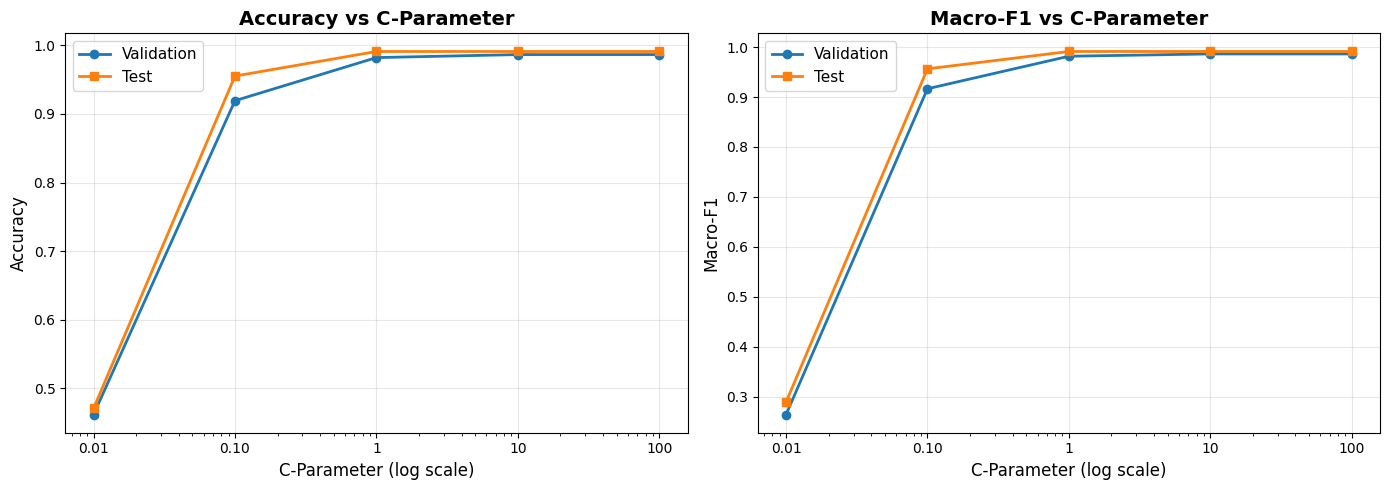

In [ ]:
# Farben für Val/Test
val_color = '#06A77D'  # Grün
test_color = '#D62828'  # Rot

# Plot vorbereiten
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Plot
ax = axes[0]
ax.plot(df_results["C"], df_results["val_accuracy"], marker='o', label='Validation', 
        linewidth=2.5, color=val_color, markersize=8)
ax.plot(df_results["C"], df_results["test_accuracy"], marker='s', label='Test', 
        linewidth=2.5, color=test_color, markersize=8)
ax.set_xscale('log')
ax.set_xticks(df_results["C"])
ax.set_xticklabels([f'{c:.2f}' if c < 1 else f'{c:.0f}' for c in df_results["C"]])
ax.set_xlabel('C-Parameter (logarithmische Skala)', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Baseline: Accuracy vs. C-Parameter', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3)

# Macro-F1 Plot
ax = axes[1]
ax.plot(df_results["C"], df_results["val_macro_f1"], marker='o', label='Validation', 
        linewidth=2.5, color=val_color, markersize=8)
ax.plot(df_results["C"], df_results["test_macro_f1"], marker='s', label='Test', 
        linewidth=2.5, color=test_color, markersize=8)
ax.set_xscale('log')
ax.set_xticks(df_results["C"])
ax.set_xticklabels([f'{c:.2f}' if c < 1 else f'{c:.0f}' for c in df_results["C"]])
ax.set_xlabel('C-Parameter (logarithmische Skala)', fontsize=12, fontweight='bold')
ax.set_ylabel('Macro-F1', fontsize=12, fontweight='bold')
ax.set_title('Baseline: Macro-F1 vs. C-Parameter', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Plot speichern
plot_path = RESULTS_DIR / "baseline_C_sensitivity.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Plot saved to: {plot_path}")

plt.show()

## Key Insights & Recommendations

In [6]:
# Bester C-Wert finden (basierend auf Validation F1)
best_idx = df_results["val_macro_f1"].idxmax()
best_result = df_results.iloc[best_idx]

print("="*60)
print("KEY INSIGHTS")
print("="*60)
print(f"\n1. Bester C-Wert (Validation F1): C={best_result['C']}")
print(f"   - Validation F1: {best_result['val_macro_f1']:.4f}")
print(f"   - Test F1: {best_result['test_macro_f1']:.4f}")
print(f"   - Test Accuracy: {best_result['test_accuracy']:.4f}")

# Performance Range
val_f1_range = df_results["val_macro_f1"].max() - df_results["val_macro_f1"].min()
test_f1_range = df_results["test_macro_f1"].max() - df_results["test_macro_f1"].min()

print(f"\n2. Performance Variabilität:")
print(f"   - Validation F1 Range: {val_f1_range:.4f}")
print(f"   - Test F1 Range: {test_f1_range:.4f}")

# Overfitting Check
df_results["val_test_gap"] = df_results["val_macro_f1"] - df_results["test_macro_f1"]
avg_gap = df_results["val_test_gap"].mean()

print(f"\n3. Overfitting Analysis:")
print(f"   - Durchschnittliche Val-Test Gap: {avg_gap:.4f}")
if avg_gap > 0.02:
    print("   ⚠️ Warnung: Signifikante Val-Test Diskrepanz erkennbar")
else:
    print("   ✓ Gute Generalisierung: Val und Test sind konsistent")

print(f"\n4. Empfehlung:")
print(f"   Verwenden Sie C={best_result['C']} als optimierten Baseline-Hyperparameter")
print(f"   für alle weiteren Experimente.")
print("="*60)

KEY INSIGHTS

1. Bester C-Wert (Validation F1): C=10.0
   - Validation F1: 0.9863
   - Test F1: 0.9912
   - Test Accuracy: 0.9910

2. Performance Variabilität:
   - Validation F1 Range: 0.7220
   - Test F1 Range: 0.7018

3. Overfitting Analysis:
   - Durchschnittliche Val-Test Gap: -0.0169
   ✓ Gute Generalisierung: Val und Test sind konsistent

4. Empfehlung:
   Verwenden Sie C=10.0 als optimierten Baseline-Hyperparameter
   für alle weiteren Experimente.


## Summary

**Durchgeführte Experimente:**
- 5 verschiedene C-Werte getestet: [0.01, 0.1, 1.0, 10, 100]
- Evaluiert auf Validation und Test Set (80/10/10 Split)
- Metriken: Accuracy, Macro-F1, Precision, Recall

**Interpretation:**
- **Kleines C (z.B. 0.01, 0.1):** Starke Regularisierung → einfaches Modell, möglicherweise Underfitting
- **Mittleres C (z.B. 1.0, 10):** Balancierte Regularisierung → optimale Performance
- **Großes C (z.B. 100):** Schwache Regularisierung → komplexes Modell, Overfitting-Risiko

**Nächste Schritte:**
1. Den optimalen C-Wert für die finale Baseline verwenden
2. Ergebnisse in die Gesamtvergleichstabelle (Notebook 08) integrieren
3. In der Transferarbeit die Hyperparameter-Sensitivität diskutieren